In [1]:
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import glob
import sys
from astroquery.jplhorizons import Horizons

In [2]:
### Change as required

main_dir = '/Users/s1523386/Documents/year1/shape_modelling/162p'
lc_dir = main_dir+'/LC_prep/raw/'
target = '162p'

files = sorted(glob.glob(lc_dir+target+'*R.txt'))
# Check this read correctly
if len(files)==0:
    print('Problem loading LC files, check path.')
    sys.exit()
else:
    print('%i LC files found for %s.'%(len(files), target))
    print('First file in list = ', files[0])
    print('Last file in list = ', files[-1])

18 LC files found for 162p.
First file in list =  /Users/s1523386/Documents/year1/shape_modelling/162p/LC_prep/raw/162p_20070517_950_R.txt
Last file in list =  /Users/s1523386/Documents/year1/shape_modelling/162p/LC_prep/raw/162p_20180711_809_R.txt


In [36]:
# Magnitudes found in the second column of each LC file, JD in first
# Calculate mean magnitude from each LC as it's read in
mjd_start = []
mjd_all=[]
mag = []
mean_mag = []
mag_all = []
mag_unc=[]
mjd = []
length_list = []
npoints=np.zeros(len(files))

for i,file in enumerate(files):
    
    count = 0
    f = open(file, 'r')
    lines = f.readlines()
    for line in lines:
        data = line.split()
        mjd_all.append(float(data[0]))
        mjd.append(float(data[0]))
        mag.append(float(data[1]))
        mag_all.append(float(data[1]))
        mag_unc.append(float(data[2]))
        count = count+1
    npoints[i] = int(count)
    mjd_start.append(mjd[0])    # MJDs at start of observing run (mid-exposure)
    print('No. mags to take mean of =', len(mag))
    length_list.append(len(mag))
    mean_mag.append(np.mean(mag))
    mjd = []
    mag = []
    
f.close()


No. mags to take mean of = 13
No. mags to take mean of = 12
No. mags to take mean of = 12
No. mags to take mean of = 30
No. mags to take mean of = 5
No. mags to take mean of = 17
No. mags to take mean of = 13
No. mags to take mean of = 29
No. mags to take mean of = 93
No. mags to take mean of = 52
No. mags to take mean of = 79
No. mags to take mean of = 21
No. mags to take mean of = 80
No. mags to take mean of = 71
No. mags to take mean of = 51
No. mags to take mean of = 17
No. mags to take mean of = 15
No. mags to take mean of = 8


In [19]:
# Obtain telescope codes from files filenames to parse Horizons database
siteid = []
for file in files:
    siteid.append(file[79:82])
print(siteid) # Check this is a list of 3-digit numbers 


['950', '950', '950', '309', '309', '809', '809', '309', '950', '950', '950', '071', '950', '950', '950', '809', '809', '809']


In [20]:
# Correct mid-exposure MJDs for light travel time before we obtain alphas, deltas and r_hs
# MJD_use = MJD_start-(delta/c)
au=1.496e11   #m
d2s=86400
mjd_use = []

for i,day in enumerate(mjd_start):
    obj = Horizons(id='90001062',location = siteid[i], epochs=day)
    eph = obj.ephemerides(quantities='20')
    deltcomet = float(eph['delta'])
    mjd_use.append(((day*d2s)-((deltcomet*au)/3.e8))/d2s)
mjd_use

[2454238.4504419076,
 2454239.36251031,
 2454240.3729025465,
 2456040.571266327,
 2456071.4737502034,
 2456093.490967207,
 2456096.4932989585,
 2456101.438880528,
 2457802.5503569725,
 2457803.5527208317,
 2457806.5423623323,
 2457811.504141046,
 2458219.455531825,
 2458220.4885629457,
 2458227.435531547,
 2458309.3739130935,
 2458310.374203054,
 2458311.370768656]

In [21]:
# Use light-time corrected MJDs to parse Horizons for delta, alpha, r_h
r_au = []
delta_au = []
alpha = []

for i in range(len(siteid)):
    obj = Horizons(id='90001066',location = siteid[i], epochs=mjd_use[i])
    eph = obj.ephemerides(quantities='19,20,24')
    
    r = float(eph['r'])
    r_au.append(r)
    
    delta = float(eph['delta'])
    delta_au.append(delta)
    alp = float(eph['alpha'])
    alpha.append(alp)

In [22]:
# Check the ephemerides are for 162P/Siding-Spring: it's changed id x3 since I started this...
print(eph)

    targetname           datetime_str       ... delta_rate  alpha 
       ---                   ---            ...   km / s     deg  
------------------ ------------------------ ... ---------- -------
162P/Siding Spring 2018-Jul-11 20:53:54.412 ... 26.0869665 12.0887


In [16]:
# Defining funciton to calculate reduced magnitude H(1,1,alpha)
# Inputs:
#    m: apparent magnitude
#    r: heliocentric distance (AU)
#    delta: geocentric distance (AU)

# Outputs:
#    h: H(1,1,alpha)
def mag_reduce(m, r, delta):
    h = m-(5*np.log10(r*delta))
    return h

In [12]:
dir_name = main_dir+'/LC_prep/dist_corr'
if not os.path.exists(dir_name):
    os.makedirs(dir_name)

count = 0       
for i,day in enumerate(mjd_all):
    if (day in mjd_start):
        #fout.close()
        count = count+1
        fout = open(dir_name+files[count-1][64:],'w+')
        #print(count, '%.6f' % day, mag_reduce(mag[i], r_au[count-1], delta_au[count-1]), mag_unc[i])
        fout.write(str('%.6f' % day)+' '+str('%.3f' %mag_reduce(mag[i], r_au[count-1], delta_au[count-1]))+' '+str(mag_unc[i])+'\n')
    else:
        #print(count, '%.6f' % day, mag_reduce(mag[i], r_au[count-1], delta_au[count-1]), mag_unc[i])
        fout.write(str('%.6f' % day)+' '+str('%.3f' % mag_reduce(mag[i], r_au[count-1], delta_au[count-1]))+' '+str(mag_unc[i])+'\n')
fout.close()   
    
        
    

In [23]:
alpha



[7.5057,
 7.6664,
 7.8417,
 4.4883,
 9.892,
 11.8385,
 11.97,
 12.1195,
 9.8697,
 9.6987,
 9.1704,
 8.2387,
 2.2635,
 2.0222,
 0.3947,
 12.0582,
 12.0751,
 12.0887]

In [43]:
mjd_all

[2454238.473696,
 2454238.475177,
 2454238.47667,
 2454238.478152,
 2454238.479633,
 2454238.481115,
 2454238.482596,
 2454238.484078,
 2454238.485582,
 2454238.487064,
 2454238.549216,
 2454238.553696,
 2454238.558152,
 2454239.385819,
 2454239.387543,
 2454239.389256,
 2454239.390993,
 2454239.392705,
 2454239.399418,
 2454239.404476,
 2454239.551745,
 2454239.553469,
 2454239.601224,
 2454239.602717,
 2454239.604198,
 2454240.396273,
 2454240.397766,
 2454240.399247,
 2454240.471122,
 2454240.472604,
 2454240.474131,
 2454240.546724,
 2454240.548205,
 2454240.549687,
 2454240.607638,
 2454240.60912,
 2454240.610613,
 2456040.641995,
 2456040.643064,
 2456040.644129,
 2456040.645204,
 2456040.646293,
 2456040.647369,
 2456040.648436,
 2456040.649499,
 2456040.650576,
 2456040.65164,
 2456040.652709,
 2456040.653783,
 2456040.654872,
 2456040.655935,
 2456040.657012,
 2456040.751519,
 2456040.752621,
 2456040.753731,
 2456040.754834,
 2456040.75593,
 2456040.75705,
 2456040.758157,
 2

In [29]:
# read in output lcs from convexinv
intensity=[]
path = '/Users/s1523386/Documents/year1/shape_modelling/162p/dist_cal_pole_scan/run_0_-90_2021_05_04/out_lcs'

filenom = path

g = open(filenom, 'r')
lines = g.readlines()

for line in lines:
    data = line.split()
    intensity.append(float(data[0]))

In [30]:
intensity

[1.04756,
 1.04834,
 1.04917,
 1.04999,
 1.05085,
 1.05175,
 1.05258,
 1.05335,
 1.0542,
 1.05533,
 1.06504,
 1.06294,
 1.06055,
 0.832545,
 0.82894,
 0.825327,
 0.821596,
 0.817875,
 0.803009,
 0.791656,
 0.651547,
 0.654428,
 0.729659,
 0.733174,
 0.738098,
 0.929526,
 0.93143,
 0.933269,
 1.00982,
 1.01065,
 1.01144,
 1.02241,
 1.02233,
 1.02219,
 0.995699,
 0.994381,
 0.992996,
 1.15657,
 1.1558,
 1.15501,
 1.15417,
 1.1533,
 1.15241,
 1.15149,
 1.15056,
 1.14958,
 1.14858,
 1.14755,
 1.1465,
 1.14539,
 1.14427,
 1.14312,
 1.00215,
 0.999678,
 0.997162,
 0.994646,
 0.992107,
 0.989501,
 0.986919,
 0.984293,
 0.981669,
 0.979022,
 0.976355,
 0.973569,
 0.970861,
 0.968164,
 0.965452,
 0.833924,
 0.831245,
 0.828591,
 0.825844,
 0.823146,
 0.561264,
 0.55852,
 0.55574,
 0.552895,
 0.549981,
 0.543892,
 0.540733,
 0.537518,
 0.534237,
 0.530891,
 0.528199,
 0.528595,
 0.529918,
 0.531601,
 0.534856,
 0.538077,
 0.540941,
 0.783511,
 0.78863,
 0.798213,
 0.802829,
 0.838863,
 0.842307,

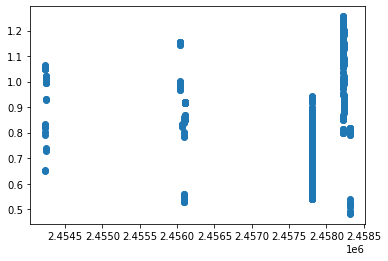

In [37]:
length_list

[13, 12, 12, 30, 5, 17, 13, 29, 93, 52, 79, 21, 80, 71, 51, 17, 15, 8]

In [39]:
alpha_indiv = []

for i,value in enumerate(length_list):
    for j in range(int(value)):
        alpha_indiv.append(alpha[i])

In [41]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(alpha_indiv,intensity)
print(slope, intercept, std_err, r_value)

-0.03954237278044004 1.157159454164836 0.0014453934464315255 -0.7406285312228644


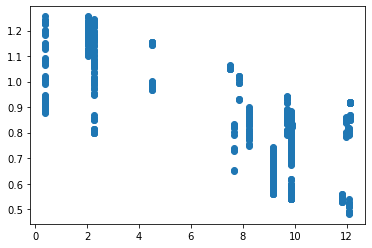

In [40]:
plt.scatter(alpha_indiv, intensity)
plt.show()